### Convolutional Auto-Encoder


### Sources

Testing/Validation: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/cifar-cnn/cifar10_cnn_solution.ipynb

Theory: https://cs231n.github.io/convolutional-networks/#conv

Theory/AE Class: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/autoencoder/convolutional-autoencoder/Convolutional_Autoencoder_Solution.ipynb

Theory/AE Class: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/cifar-cnn/cifar10_cnn_solution.ipynb


### Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
from collections import OrderedDict
from pathlib import Path
import uuid
#import pydicom
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Import essential libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
#from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import random
%matplotlib inline
import torch.nn as nn
import torch.optim as optim
import gzip

### Data Preparation

In [2]:
torch.cuda.empty_cache()

In [3]:
cxr_root_path = "/media/Data/ComputerVision/mimic_cxr_jpg_small_chest_radiograph/data/physionet.org/files/mimic-cxr-jpg/2.0.0/"
record_df = pd.read_csv('{}/cxr-record-list.csv.gz'.format(cxr_root_path), sep=',')
record_df.head()

,subject_id,study_id,dicom_id,path
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...


In [4]:
df_split = pd.read_csv('{}/mimic-cxr-2.0.0-split.csv.gz'.format(cxr_root_path))
dataset = df_split.merge(record_df, on=['subject_id', 'study_id', 'dicom_id'], how='left')
num_images=len(dataset)
print(num_images)

377110


In [5]:
dataset['split'].value_counts()

train       368960
test          5159
validate      2991
Name: split, dtype: int64

In [7]:
dataset['subject_id'].nunique()

65379

In [8]:
dataset['study_id'].nunique()

227835

### Selecting Portion of Data

In [9]:
dataset=dataset

### Selecting Device

In [10]:
import torch.optim as optim
#  use gpu if available
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device('cuda:2')
device= torch.device('cuda:{}'.format(2))
#device='cpu'
print(device)


cuda:2


In [11]:
class CustomDatasetFromImages(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms=None): 
        self.dataframe = dataframe
        self.transforms = transforms
    def __getitem__(self, index):
        imagepath=self.dataframe["path"].iloc[index]
        imagepath=cxr_root_path+imagepath[:-4]+'.jpg'
        image=Image.open(imagepath)
        if self.transforms is not None:
            image=self.transforms(image)
        return image
    def __len__(self):
        return len(self.dataframe)

In [12]:
train_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                            torchvision.transforms.RandomRotation((-10, 10)),
                                            torchvision.transforms.ToTensor()])
valid_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),torchvision.transforms.ToTensor()])

In [13]:
train_set=CustomDatasetFromImages(dataset.loc[dataset['split']=='train'], transforms=train_Aug)
valid_set=CustomDatasetFromImages(dataset.loc[dataset['split']=='validate'], transforms=valid_Aug)
test_set=CustomDatasetFromImages(dataset.loc[dataset['split']=='test'], transforms=valid_Aug)
trainloader= torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True) 
validloader= torch.utils.data.DataLoader(valid_set, batch_size=64,shuffle=False)
testloader=torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 24), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 24, 3, padding=1)
        # conv layer (depth from 24 --> 32), 3x3 kernels
        self.conv3 = nn.Conv2d(24, 32, 3, padding=1)
        # conv layer (depth from 32 --> 40), 3x3 kernels
        self.conv4 = nn.Conv2d(32, 40, 3, padding=1)
        # pooling layer to reduce x-y dims(each) by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        #FULLY CONNECTED LAYERS
        
        self.lin1=nn.Linear(7840, 2560, bias=True)
        self.lin2=nn.Linear(2560, 824, bias=True)
        self.lin3=nn.Linear(824,256,bias=True)
        self.i_lin1=nn.Linear(256, 824, bias=True)
        self.i_lin2=nn.Linear(824, 2560, bias=True)
        self.i_lin3=nn.Linear(2560,7840,bias=True)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(40, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32,24, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(24, 16, 2, stride=2)
        self.t_conv4 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        
        #CONVOLUTIONAL PART
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = self.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        x = self.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        x = self.relu(self.conv4(x))
        x = self.pool(x)  # compressed representation
        # LINEAR PART
        x=x.view(-1,7840)
        x=self.relu(self.lin1(x))
        x=self.relu(self.lin2(x))
        x=self.relu(self.lin3(x))
        
        #Latent Space
        z=x
        
    
        ## decode ##
        
                
        #LINEAR PART 
        x=self.relu(self.i_lin1(x))
        x=self.relu(self.i_lin2(x))
        x=self.relu(self.i_lin3(x))
        #print(x.size())
        #x=nn.Unflatten(x,(64,40,14, 14))
        x=x.view(-1, 40,14,14)
        #print(x.size())

        
        #CONVOLUTIONAL PART
        # add transpose conv layers, with relu activation function
        x = self.relu(self.t_conv1(x))
        x = self.relu(self.t_conv2(x))
        x = self.relu(self.t_conv3(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv4(x))
                
        return x,z

In [15]:
learning_rate = 1e-3

In [16]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model=ConvAutoencoder().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

### Training and Validation

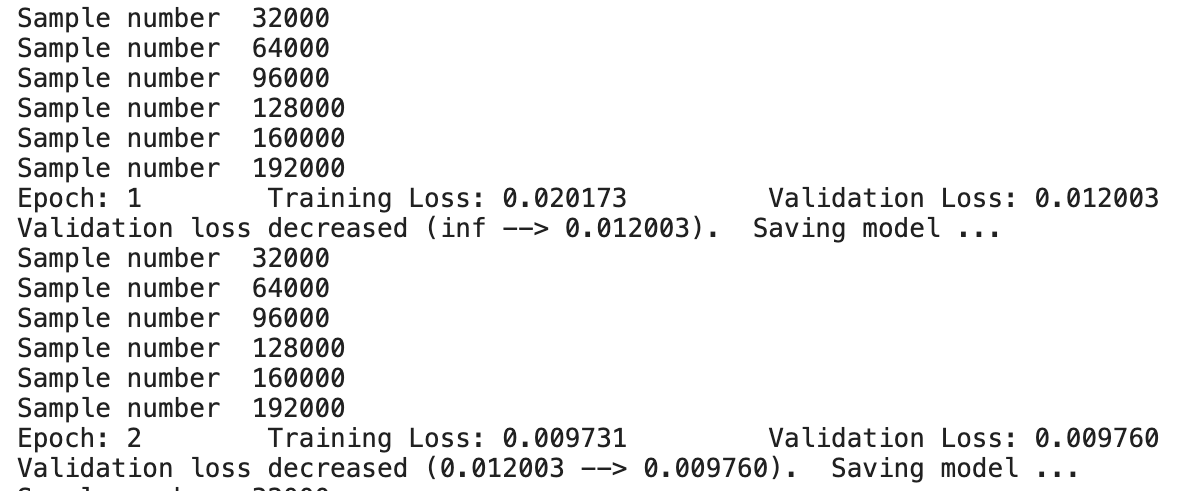

(3rd epoch had around 0.0082 of training and 0.0084 of validation loss I believe)

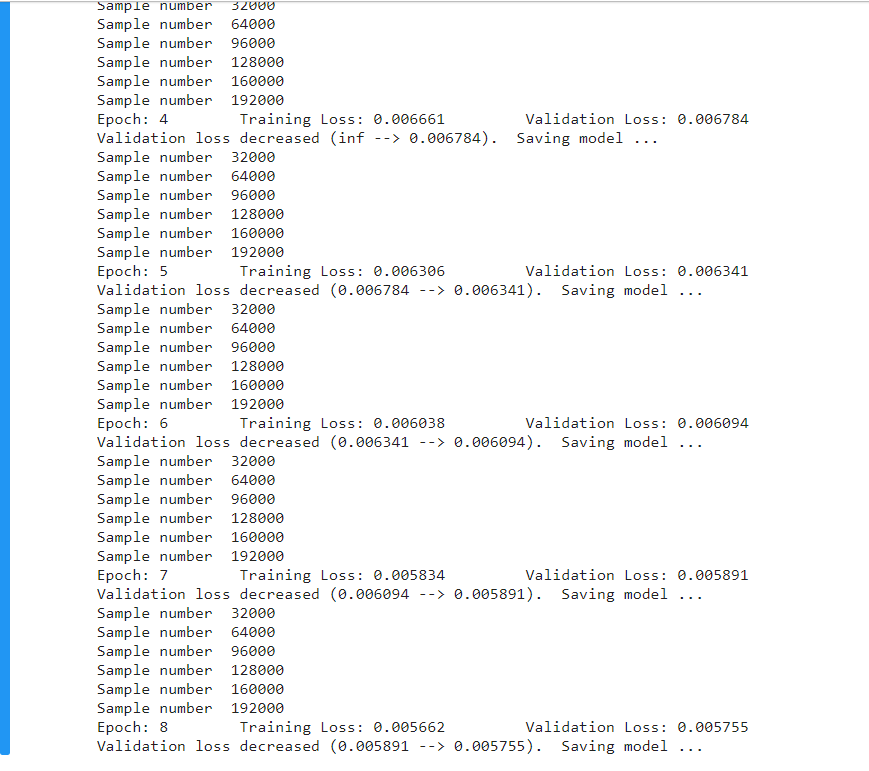

In [17]:
model.load_state_dict(torch.load('model_conv_more_layers.pt'))


<All keys matched successfully>

In [18]:
optimizer.load_state_dict(torch.load('optimizer_conv_more_layers.pt'))

In [ ]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss
train_loss_list=[0.020173,0.009731,0.0082,0.006661,0.006306,0.006038,0.005834,0.005662]
valid_loss_list=[0.012003,0.009760,0.0084,0.006784,0.006341,0.006094,0.005891,0.005755]
for epoch in range(9, n_epochs+1):
    number_of_batch=0
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data in trainloader:
        # move tensors to GPU if CUDA is available
        # clear the gradients of all optimized variables
        number_of_batch=number_of_batch+1
        data=data.to(device)
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output,z = model(data)
        # calculate the batch loss
        loss = criterion(output, data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        if (number_of_batch%500==0):
            sample_number=number_of_batch*64
            print("Sample number ",sample_number)
        
        
        
    # validate the model #
    model.eval()
    for data in validloader:
        # move tensors to GPU if CUDA is available
        # forward pass: compute predicted outputs by passing inputs to the model
        data=data.to(device)
        output,z = model(data)
        # calculate the batch loss
        loss = criterion(output, data)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_conv_more_layers.pt')
        torch.save(optimizer.state_dict(),'optimizer_conv_more_layers.pt')
        valid_loss_min = valid_loss


### Plotting Loss function across epochs

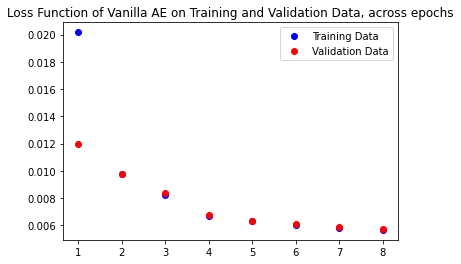

In [18]:
#print(train_loss_list[0])
train_loss_list=[0.020173,0.009731,0.0082,0.006661,0.006306,0.006038,0.005834,0.005662]
valid_loss_list=[0.012003,0.009760,0.0084,0.006784,0.006341,0.006094,0.005891,0.005755]
plt.plot(range(1,len(train_loss_list)+1),train_loss_list,'bo')
plt.plot(range(1,len(train_loss_list)+1),valid_loss_list,'ro')
plt.title("Loss Function of Vanilla AE on Training and Validation Data, across epochs")
plt.legend(['Training Data','Validation Data'])
plt.show()

### Plotting validation results

torch.Size([16, 1, 224, 224])


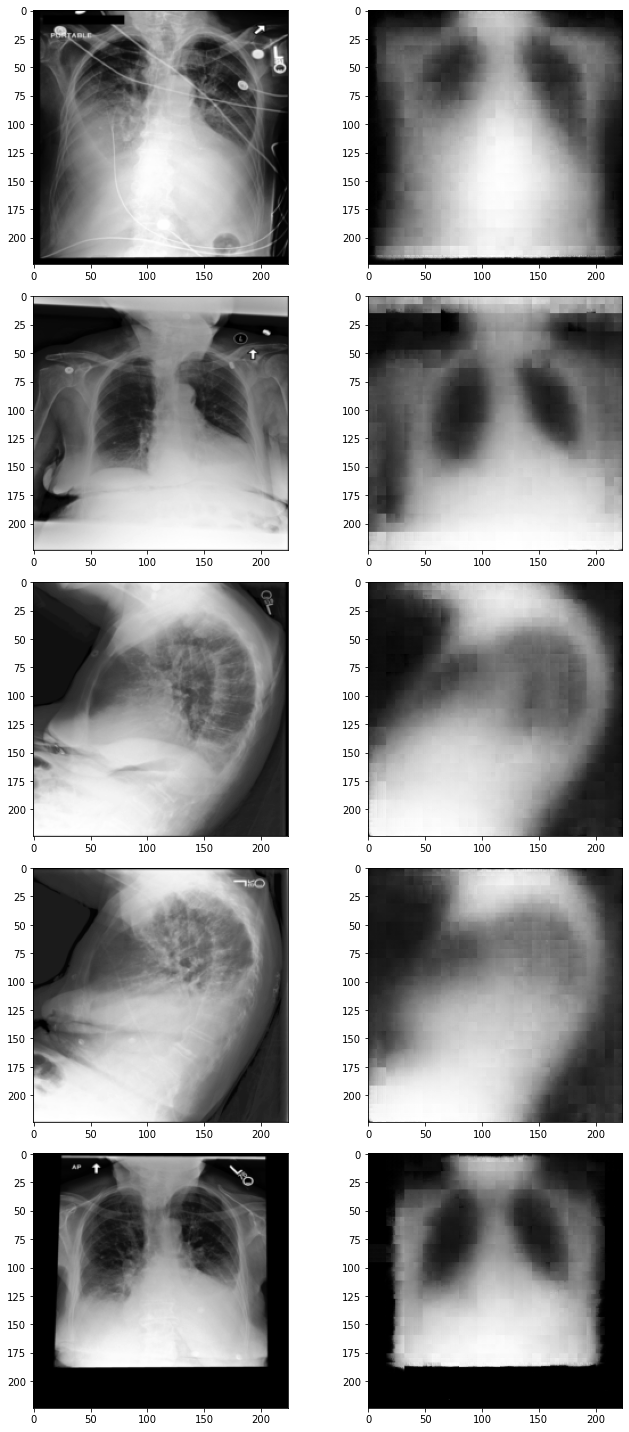

In [56]:
with torch.no_grad():
    # obtain one batch of test images
    dataiter = iter(validloader)
    images= dataiter.next()
    images.numpy()
    
    # move model inputs to cuda, if GPU available
    #images = images.cuda()
    images=images.to(device)
    
    print(images.size())
    # get sample outputs
    output,z = model(images)

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(10, 20))
    for idx in range(5):
        ax = fig.add_subplot(5,2, 1+2*idx)
        im=np.reshape(images[idx].cpu(),(224,224))
        ax.imshow(im,cmap='gray')
        ax2 = fig.add_subplot(5,2, 2+2*idx)
        im2=np.reshape(output[idx].cpu(),(224,224))
        ax2.imshow(im2,cmap='gray')
    fig.tight_layout()
    

### Latent Space Observation

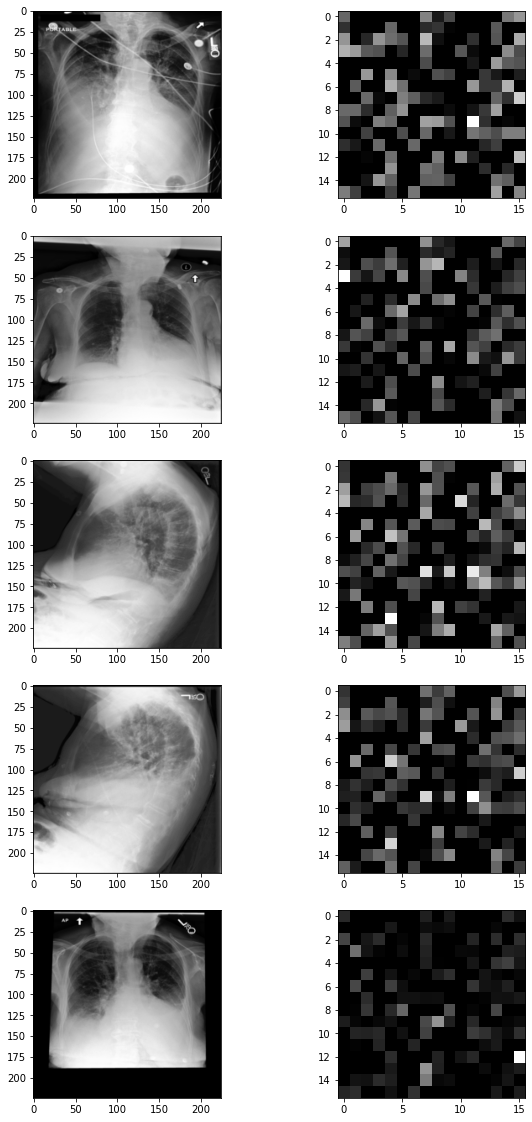

In [57]:
fig2=plt.figure(figsize=(10,20))
for idx in range(5):
    ax3 = fig2.add_subplot(5,2, 1+2*idx)
    im=np.reshape(images[idx].cpu(),(224,224))
    ax3.imshow(im,cmap='gray')
    ax4 = fig2.add_subplot(5,2, 2+2*idx)
    im2=np.reshape(z[idx].cpu(),(16,16))
    ax4.imshow(im2,cmap='gray')
plt.show()

## Similarity Measurement

#### Generating Latent Spaces of Testing Set

In [19]:
latent_spaces=torch.zeros([1,256], dtype=torch.int32).to(device)
with torch.no_grad():
    for data in testloader:
        data=data.to(device)
        output,z = model(data)
        latent_spaces=torch.cat((latent_spaces,z),dim=0)

In [20]:
print(latent_spaces.size())

torch.Size([5160, 256])


#### Getting Input

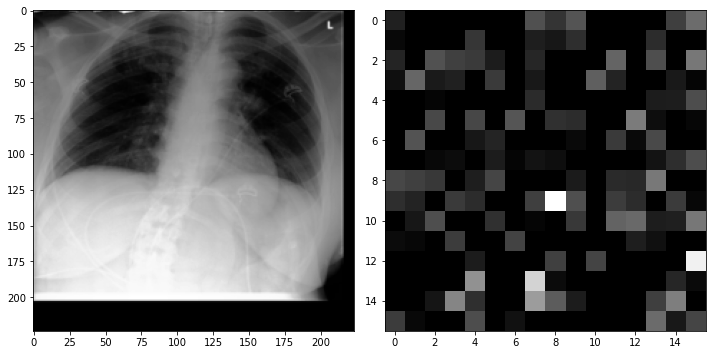

In [21]:
inputloader=torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=6,shuffle=False)
with torch.no_grad():
    # obtain one batch of test images
    dataiter = iter(inputloader)
    image= dataiter.next()
    image.numpy()

    # move model inputs to cuda, if GPU available
    image = image.to(device)

    # get sample outputs
    output,z = model(image)
    fig = plt.figure(figsize=(10, 20))
    ax = fig.add_subplot(1,2,1)
    im=np.reshape(image.cpu(),(224,224))
    ax.imshow(im,cmap='gray')
    ax2 = fig.add_subplot(1,2, 2)
    im2=np.reshape(z.cpu(),(16,16))
    ax2.imshow(im2,cmap='gray')
    fig.tight_layout()

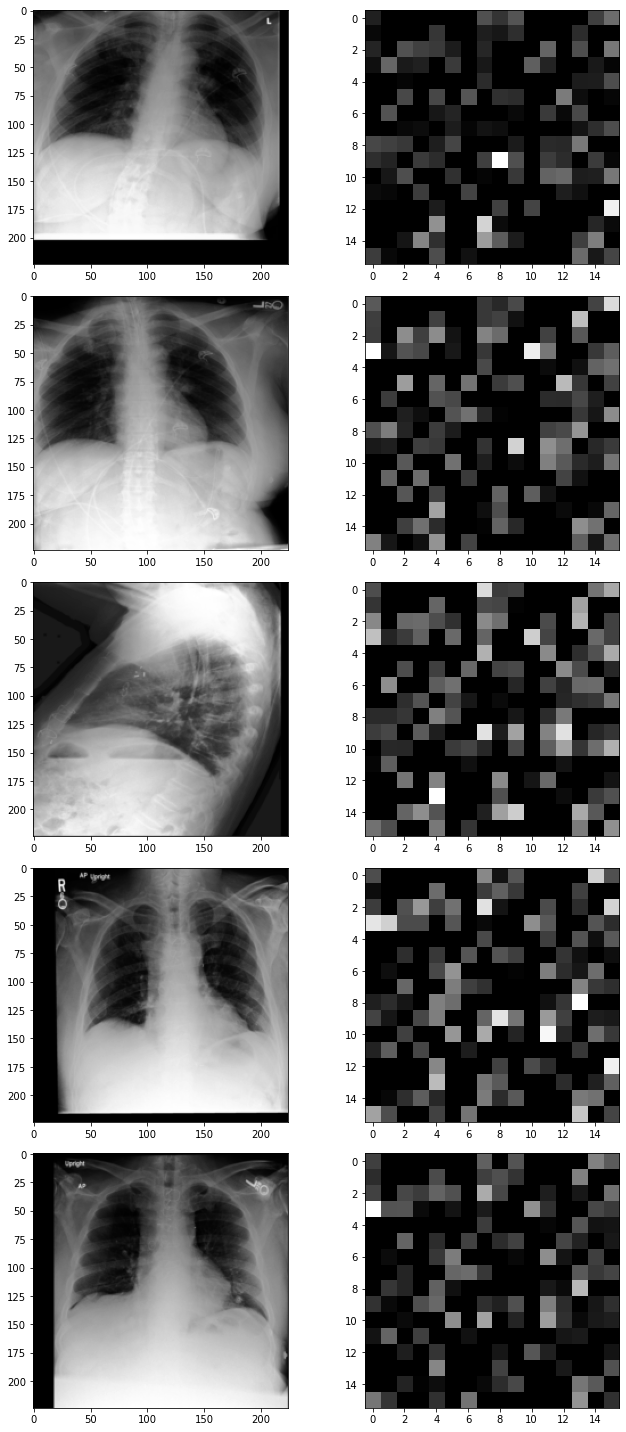

In [27]:
inputloader=torch.utils.data.DataLoader(test_set, batch_size=5, num_workers=6,shuffle=False)
with torch.no_grad():
    # obtain one batch of test images
    dataiter = iter(inputloader)
    images= dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    images = images.to(device)

    # get sample outputs
    output,z = model(image)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(10, 20))
    for idx in range(5):
        ax = fig.add_subplot(5,2, 1+2*idx)
        im=np.reshape(images[idx].cpu(),(224,224))
        ax.imshow(im,cmap='gray')
        ax2 = fig.add_subplot(5,2, 2+2*idx)
        im2=np.reshape(z[idx].cpu(),(16,16))
        ax2.imshow(im2,cmap='gray')
    fig.tight_layout()

#### Calculating Losses

In [70]:
loss=nn.MSELoss()
mses=[]
min_index=0
min_mse=np.Inf
for i in range(latent_spaces.size(dim=0)):
    mse=loss(z[1],latent_spaces[i,::])
    mses.append(mse)
    if mse<min_mse:
        min_mse=mse
        min_index=i
min_indexes=[]
min_indexes=np.argsort(mses)[:5]
print(min_indexes)

[   2 4484 4307 4482 3784]


#### Retrieving Similar Images

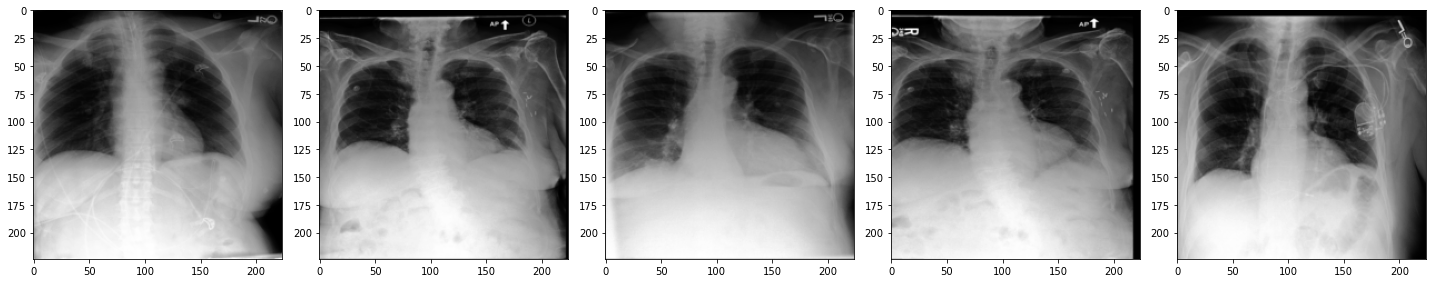

In [71]:
#similar_set=CustomDatasetFromImages(dataset.loc[dataset['split']=='test'], transforms=valid_Aug)
fig = plt.figure(figsize=(20, 30))
for index in range(len(min_indexes)):
    ax = fig.add_subplot(1,5, index+1)
    im=np.reshape(test_set[min_indexes[index]-1].cpu(),(224,224))
    ax.imshow(im,cmap='gray')
fig.tight_layout()

The first image is the comparison image, while the 4 other ones are the most similar ones.

#### Integrating everything in a Loop